In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset.git

Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 27.80 MiB/s, done.


In [ ]:
!ls brain-tumor-classification-dataset/

Testing  Training


In [ ]:
train_data_dir = '/content/brain-tumor-classification-dataset/Training'
test_data_dir = '/content/brain-tumor-classification-dataset/Testing'

In [ ]:
# Image parameters
img_height, img_width = 128, 128
batch_size = 16

In [ ]:
# Create data generators for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 2297 images belonging to 4 classes.


In [ ]:
# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 573 images belonging to 4 classes.


In [ ]:
# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 394 images belonging to 4 classes.


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
import tensorflow as tf
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_mask_rcnn(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # Backbone network (encoder)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    conv1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool1)
    conv2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Mask head (decoder for segmentation)
    up1 = UpSampling2D((2, 2))(pool3)
    conv3_resized = Conv2D(256, (1, 1), padding='same')(conv3)
    merge1 = concatenate([up1, conv3_resized])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merge1)
    conv4 = tf.keras.layers.Dropout(0.5)(conv4)

    up2 = UpSampling2D((2, 2))(conv4)
    conv2_resized = Conv2D(128, (1, 1), padding='same')(conv2)
    merge2 = concatenate([up2, conv2_resized])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merge2)
    conv5 = tf.keras.layers.Dropout(0.5)(conv5)

    mask_output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    # Classification head (for tumor type)
    flat = GlobalAveragePooling2D()(pool3)
    class_output = Dense(num_classes, activation='softmax')(flat)

    model = Model(inputs, [class_output, mask_output])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
        loss=['categorical_crossentropy', 'binary_crossentropy'],
        metrics=['accuracy', 'accuracy']  # One metric for each output
    )

    return model

In [ ]:
# Build the model
model = build_mask_rcnn(input_shape=(img_height, img_width, 3), num_classes=train_generator.num_classes)

In [ ]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 256)    │              0 │ max_pooling2d_2[0][0]  │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │         65,792 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │        589,952 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 64, 64, 128)    │              0 │ dropout_2[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │         16,512 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 1,191,685 (4.55 MB)

 Trainable params: 1,191,685 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('mask_rcnn_brain_tumor.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'bias', 'kernel', 'bias', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - dense_2_accuracy: 0.2839 - loss: 1.8476 - val_dense_2_accuracy: 0.3752 - val_loss: 1.6345
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - dense_2_accuracy: 0.4822 - loss: 1.4765 - val_dense_2_accuracy: 0.3490 - val_loss: 1.4986
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - dense_2_accuracy: 0.5376 - loss: 1.3072 - val_dense_2_accuracy: 0.3944 - val_loss: 1.4499
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - dense_2_accuracy: 0.5679 - loss: 1.2296 - val_dense_2_accuracy: 0.4276 - val_loss: 1.4115
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - dense_2_accuracy: 0.5856 - loss: 1.1826 - val_dense_2_accuracy: 0.3962 - val_loss: 1.3886
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - dense_2_accuracy: 0.5631 - loss: 1.1565 - val_dense_2_accuracy: 0.3997 - val_loss: 1.3503
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - dense_2_accuracy: 0.6111 - loss: 1.0902 - val_dense_2_accuracy: 0.4346 - val_loss: 1.3

In [ ]:
# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print the results
print(f"Test Results: {results}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - dense_2_accuracy: 0.4063 - loss: 1.5528
Test Results: [1.590120553970337, 0.3781725764274597]


In [ ]:
print(history.history.keys())


dict_keys(['dense_2_accuracy', 'loss', 'val_dense_2_accuracy', 'val_loss'])


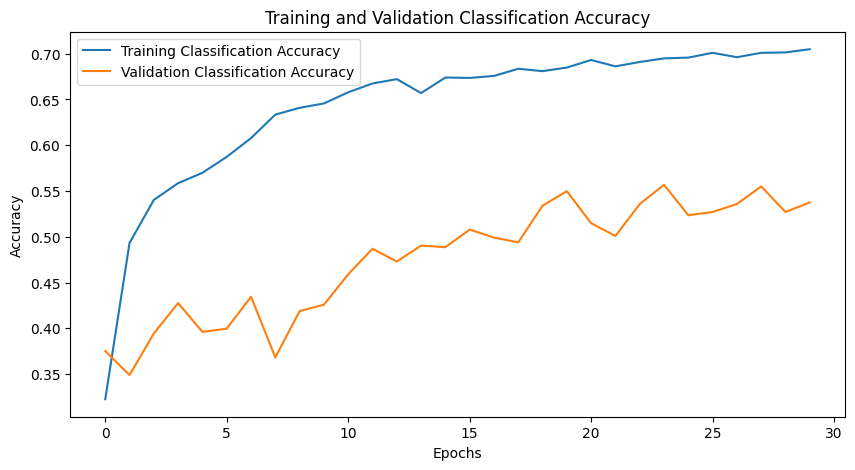

In [ ]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy for Classification
plt.figure(figsize=(10, 5))
plt.plot(history.history['dense_2_accuracy'], label='Training Classification Accuracy')
plt.plot(history.history['val_dense_2_accuracy'], label='Validation Classification Accuracy')
plt.title('Training and Validation Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


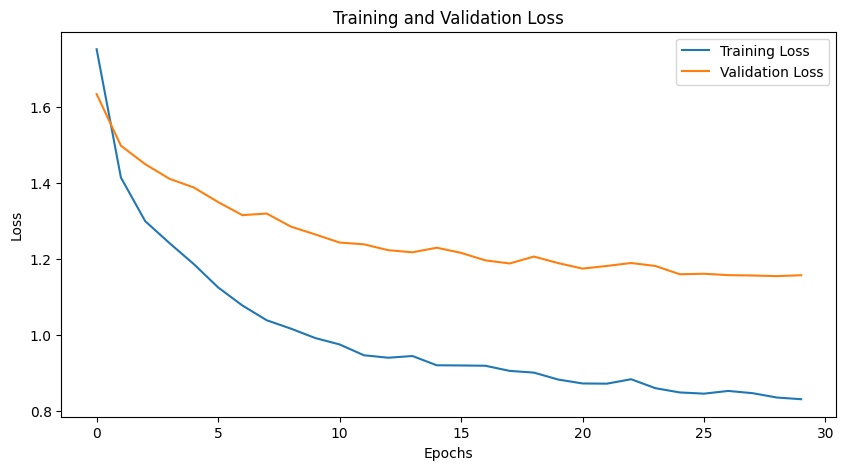

In [ ]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
